# Performing Validation of generatin FAC coordinate transformation matrix
Date Created: 31-Oct-2025

Date Modified: 3-Nov-2025

Author: Regis John

In [1]:
import pyspedas
import numpy as np
import matplotlib.pyplot as plt

In [2]:
trange = ['2015-12-09/05:03:55', '2015-12-09/05:03:59']

Reading in magnetic and electric field data:

In [7]:
fgm_vars = pyspedas.mms.fgm(trange=trange, probe=1, data_rate='brst',
                            varformat='mms1_fgm_b_gse_brst_l2', time_clip=True)

03-Nov-25 17:34:03: Loading files for group: probe: 1, drate: brst, level: l2, datatype: , after sorting and filtering:
03-Nov-25 17:34:03: /Users/rejohn/Data_Speedas/mms/mms1/fgm/brst/l2/2015/12/09/mms1_fgm_brst_l2_20151209050044_v4.22.0.cdf


In [8]:
edp_vars = pyspedas.mms.edp(trange=trange,
                            probe=1,
                            data_rate='brst',
                            varnames=['mms1_edp_dce_gse_brst_l2', 'mms1_edp_dce_par_epar_brst_l2'],
                            time_clip=True)

03-Nov-25 17:34:04: Loading files for group: probe: 1, drate: brst, level: l2, datatype: dce, after sorting and filtering:
03-Nov-25 17:34:04: /Users/rejohn/Data_Speedas/mms/mms1/edp/brst/l2/dce/2015/12/09/mms1_edp_brst_l2_dce_20151209050044_v2.2.0.cdf


In [9]:
pyspedas.tplot_names()

0 : mms1_fgm_b_gse_brst_l2
1 : bvec_gse
2 : mms1_fgm_b_gse_brst_l2_btot
3 : evec_gse
4 : epar_gse
5 : mms1_fgm_b_gse_brst_l2_bvec
6 : mms1_edp_dce_gse_brst_l2
7 : mms1_edp_dce_par_epar_brst_l2


['mms1_fgm_b_gse_brst_l2',
 'bvec_gse',
 'mms1_fgm_b_gse_brst_l2_btot',
 'evec_gse',
 'epar_gse',
 'mms1_fgm_b_gse_brst_l2_bvec',
 'mms1_edp_dce_gse_brst_l2',
 'mms1_edp_dce_par_epar_brst_l2']

In [10]:
pyspedas.tplot_rename('mms1_fgm_b_gse_brst_l2_bvec', 'bvec_gse')
pyspedas.tplot_rename('mms1_edp_dce_gse_brst_l2', 'evec_gse')
pyspedas.tplot_rename('mms1_edp_dce_par_epar_brst_l2', 'epar_gse')

### Downsampling to DES cadence of 30 ms

In [11]:
# Define target cadence
des_cadence = 0.03  # seconds or 30 ms

In [12]:
# 1. Downsample magnetic field (native ~128 Hz → 33 Hz)
pyspedas.avg_data('bvec_gse', res=des_cadence, newname='bvec_gse_avg')

03-Nov-25 17:34:11: avg_data was applied to: bvec_gse_avg


['bvec_gse_avg']

In [13]:
# 2. Downsample electric field (native 8192 Hz → 33 Hz)
pyspedas.avg_data('evec_gse', res=des_cadence, newname='evec_gse_avg')

03-Nov-25 17:34:14: avg_data was applied to: evec_gse_avg


['evec_gse_avg']

In [14]:
# 2. Downsample parallel electric field (native 8192 Hz → 33 Hz)
pyspedas.avg_data('epar_gse', res=des_cadence, newname='epar_gse_avg')

03-Nov-25 17:37:08: avg_data was applied to: epar_gse_avg


['epar_gse_avg']

## Testing FAC matrix implementation

To validate the inbuilt fac subroutine in PySPEDAS, we perform the following checks:

1. Plot the raw field-aligned electric field ($E_{\parallel}$) from MMS data.
2. Use the fac subroutine to compute $E_{\parallel}$ and plot the result.
3. Independently estimate the magnetic field direction, project the electric field onto it, and normalize by |B| to obtain $E_{\parallel}$.

If all three methods yield consistent $E_{\parallel}$ profiles, the transformation is verified.

### 1. Raw field-aligned electric field ($E_{\parallel}$) from MMS data:

In [15]:
times, epar_gse_avg = pyspedas.get_data('epar_gse_avg')
epar_gse_avg_noerr = epar_gse_avg[:, 1]  # Exclude error component
pyspedas.store_data('epar_gse_avg_noerr', data={'x': times, 'y': epar_gse_avg_noerr})

True

### 2. Estimating $E_{\parallel}$ using the inbuilt FAC functions:

In [16]:
# Using inbuilt FAC functions:
pyspedas.fac_matrix_make(mag_var_name='bvec_gse_avg', other_dim='Xgse', newname='fac_matrix')

03-Nov-25 17:37:44: store_data: Neither data array nor newname supplied, nothing to do.


'fac_matrix'

In [18]:
# Rotate the interpolated E vector using the created matrix
print("Rotating evec_gse_avg to FAC coordinates...")
pyspedas.tvector_rotate(mat_var_in='fac_matrix', vec_var_in='evec_gse_avg', 
                        newname='evec_gse_fac')

03-Nov-25 17:38:29: Setting coordinate system for evec_gse_fac


Rotating evec_gse_avg to FAC coordinates...


['evec_gse_fac']

In [19]:
_, evec_gse_fac = pyspedas.get_data('evec_gse_fac')

In [20]:
epar_gse_fac = evec_gse_fac[:, 2]  # Z component (parallel to B in FAC)

In [21]:
pyspedas.store_data('epar_gse_fac', data={'x': times, 'y': epar_gse_fac})

True

### 3. Computing $E_{\parallel}$ using projection:
We normalize the B-field (bvec_gse) to get the unit vector (bhat_gse).

In [22]:
pyspedas.tnormalize('bvec_gse_avg', newname='bhat_gse')

'bhat_gse'

In [ ]:
times, evec_gse_avg = pyspedas.

***NOTE***: pyspedas.tplot(['evec_gse','evec_gse_avg'])

Then dot product the E-field (evec_gse_s) with the B-field unit vector (bhat_gse):

In [ ]:
times, bhat_gse = pyspedas.get_data('bhat_gse')
times, evec_gse_avg = pyspedas.get_data('evec_gse_avg')

In [40]:
np.dot(bhat_gse, evec_gse_avg)

ValueError: shapes (133,3) and (133,3) not aligned: 3 (dim 1) != 133 (dim 0)

In [24]:
type(timesb), type(timese)

(numpy.ndarray, numpy.ndarray)

In [25]:
np.array_equal(timesb, timese)

False

In [36]:
a = timesb-timesb[0]

In [37]:
b = (timese-timese[0])

In [39]:
a-b

array([ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
       -2.38418579e-07,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00, -2.38418579e-07,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  

In [33]:
1/8192

0.0001220703125

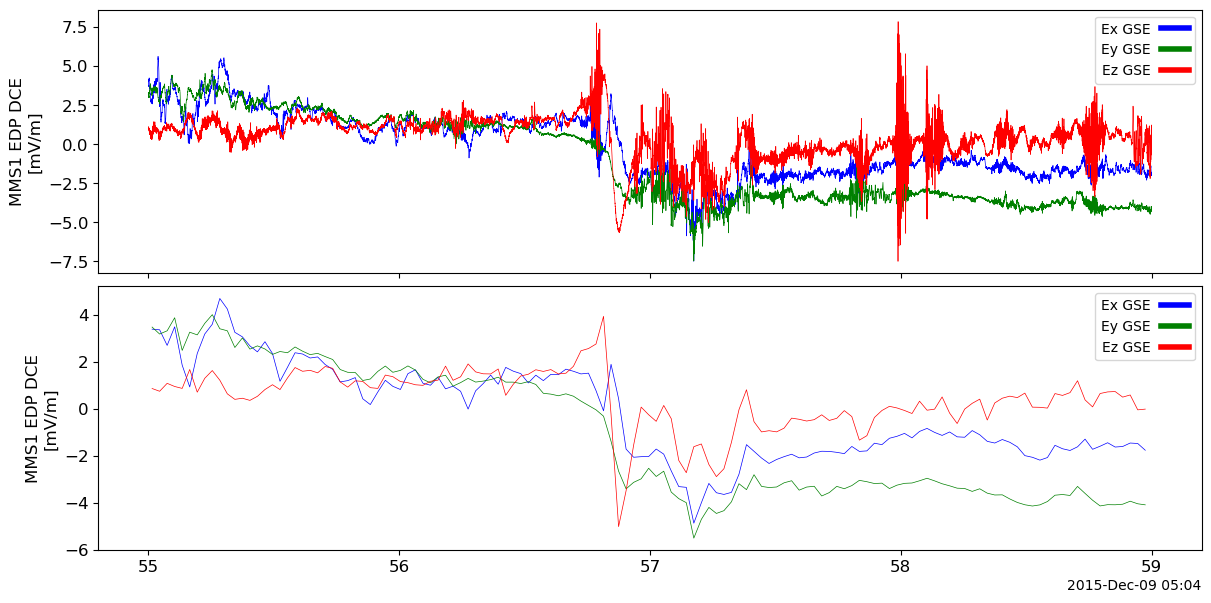

In [28]:
pyspedas.tplot(['evec_gse','evec_gse_avg'])

In [13]:
pyspedas.tdotp('evec_gse_avg', 'bhat_gse', newname='epar_gse_dotp')

03-Nov-25 16:56:01: store_data: epar_gse_dotp has empty y component, cannot create variable


'epar_gse_dotp'

### Comparing the plots:

In [ ]:
pyspedas.options('epar_gse_s_noerr', 'legend_names', 'Raw $E_{\\parallel}$')
pyspedas.options('epar_gse_s_noerr', 'ytitle', '$E_{\\parallel}$')

pyspedas.options('epar_gse_s_fac', 'legend_names', 'FAC $E_{\\parallel}$')
pyspedas.options('epar_gse_s_fac', 'ytitle', '$E_{\\parallel}$')

pyspedas.options('epar_gse_s_dotp', 'legend_names', 'Projection $E_{\\parallel}$')
pyspedas.options('epar_gse_s_dotp', 'ytitle', '$E_{\\parallel}$')

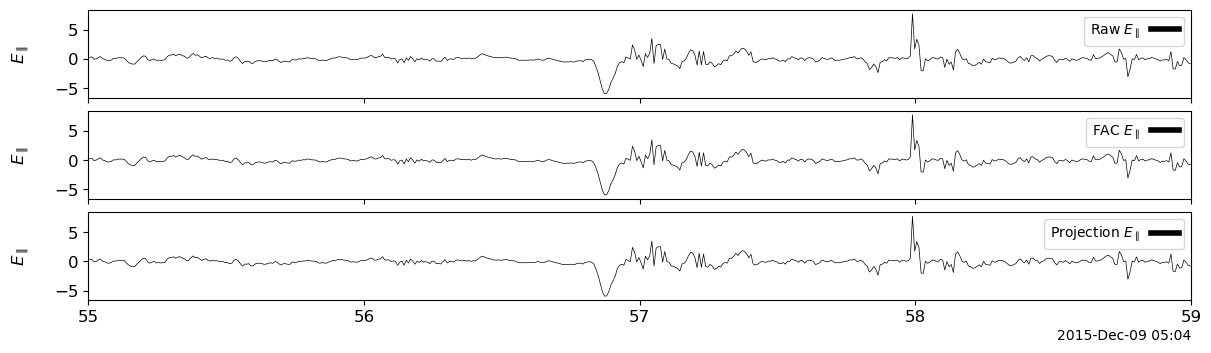

In [ ]:
pyspedas.tplot(['epar_gse_s_noerr', 'epar_gse_s_fac', 'epar_gse_s_dotp'], xsize=12, ysize=3.5)

In [ ]:
import matplotlib.pyplot as plt
from pytplot import get_data

# Extract data from PySPEDAS variables
times_noerr, data_noerr = get_data('epar_gse_s_noerr')
times_fac, data_fac = get_data('epar_gse_s_fac')
times_dotp, data_dotp = get_data('epar_gse_s_dotp')

# Create figure and axis using object-oriented API
fig, ax = plt.subplots(figsize=(12, 3.5))  # Explicitly sets aspect ratio

# Plot each trace with different line styles
ax.plot(times_noerr, data_noerr, label='Raw $E_{\\parallel}$', linestyle='-')
ax.plot(times_fac, data_fac, label='FAC $E_{\\parallel}$', linestyle='--')
ax.plot(times_dotp, data_dotp, label='Projection $E_{\\parallel}$', linestyle=':')

# Axis labels and legend
ax.set_ylabel('$E_{\\parallel}$')
ax.set_xlabel('Time')
ax.legend()
fig.tight_layout()
plt.show()
